In [119]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import RidgeCV, LassoCV, Lasso
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate


In [18]:
data = pd.read_csv('traindata.csv')
data = data.drop(['id','price','date', 'price/sqft', 'rootprice/sqft'], axis=1)
X_train = data.drop(['log price'], axis=1)
y_train = data['log price']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [117]:
ridge = RidgeCV(alphas=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.8, 1])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_

new_alphas = [x*alpha for x in [0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45]]

ridge_best = RidgeCV(alphas=new_alphas)
ridge_best.fit(X_train, y_train)
alpha_best = ridge_best.alpha_
print("best alpha: ", alpha_best)

y_pred_train = ridge_best.predict(X_train)
print("Train RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train)))

y_pred = ridge_best.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE: ", rmse_ridge)


best alpha:  0.255
Train RMSE:  0.2343906799030603
Test RMSE:  0.23838821658471995


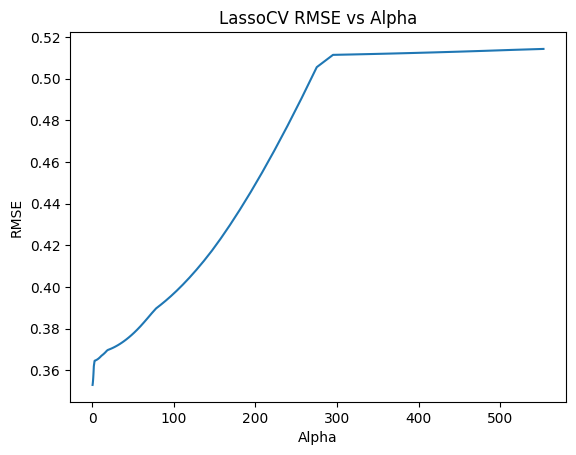

Best alpha: 0.5526859501877915
RMSE using best alpha: 0.3546325271642414


In [102]:
lasso = LassoCV(cv = 10)
lasso.fit(X_train, y_train)
rmse_lasso = np.sqrt(np.mean(lasso.mse_path_, axis=1))

plt.plot(lasso.alphas_, rmse_lasso)
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('LassoCV RMSE vs Alpha')
plt.show()

best_alpha = lasso.alpha_
print('Best alpha:', best_alpha)

lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE using best alpha:', rmse_lasso)

In [112]:
model = AdaBoostRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model using mean squared error
rmse_adaboost = np.sqrt(mean_squared_error(y_test, y_pred))
print("Mean Squared Error: ", rmse_adaboost)

Mean Squared Error:  0.24786262855005345


In [111]:
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.032611915601110306


In [4]:
model_params = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [100, 110, 120],
    'learning_rate': [0.1],
    'max_depth': [7]
}

grid_search = GridSearchCV(estimator=model_params, param_grid=param_grid, cv=10)
grid_search.fit(X_train, y_train)
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 120}
Best score:  0.9013975772098508


In [108]:
grid_search.cv_results_['mean_test_score']
y_pred = grid_search.best_estimator_.predict(X_test)
rmse_gradient = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_gradient

0.1646728541196589

In [121]:
rmse_table = [['Rideg regression',rmse_ridge], ['Lasso regression', rmse_lasso], ['AdaBoost', rmse_adaboost], ['GradientBoost', rmse_gradient]]
print(tabulate(rmse_table, headers=['Model Name', "RMSE"], tablefmt="psql"))

+------------------+----------+
| Model Name       |     RMSE |
|------------------+----------|
| Rideg regression | 0.238388 |
| Lasso regression | 0.354633 |
| AdaBoost         | 0.247863 |
| GradientBoost    | 0.164673 |
+------------------+----------+


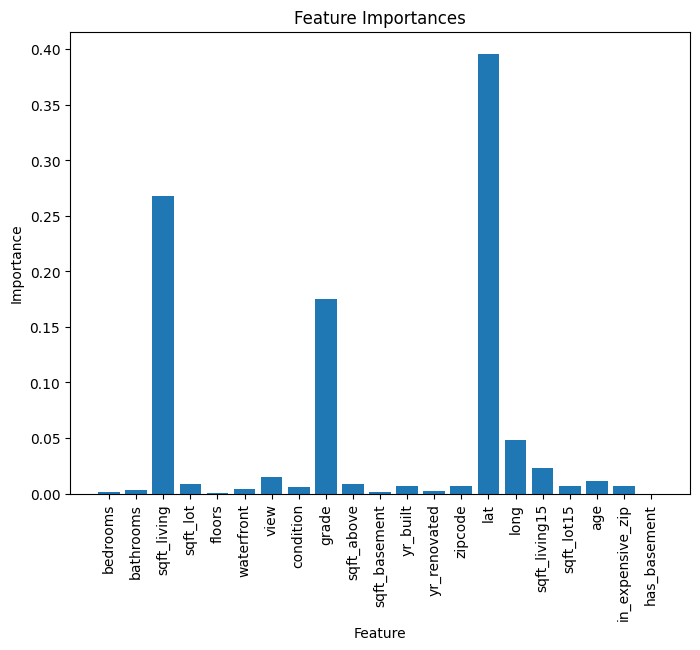

In [122]:
feature_importances  = grid_search.best_estimator_.feature_importances_
feature_names = list(X_train.columns)

feature_df = pd.DataFrame()
feature_df['importance'] = feature_importances
feature_df['feature'] = feature_names

plt.figure(figsize=(8, 6))
plt.bar(feature_df['feature'], feature_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [127]:
X_train_importance = X_train[['sqft_living','view','grade','lat', 'long','age', 'in_expensive_zip']]
X_test_importance = X_test[['sqft_living','view','grade','lat', 'long','age', 'in_expensive_zip']]

grid_search_importance = GridSearchCV(estimator=model_params, param_grid=param_grid, cv=10)
grid_search_importance.fit(X_train_importance, y_train)
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 120}
Best score:  0.9013975772098508


In [129]:
grid_search_importance.cv_results_['mean_test_score']
y_pred_importance = grid_search_importance.best_estimator_.predict(X_test_importance)
rmse_gradient_importance = np.sqrt(mean_squared_error(y_test, y_pred_importance))
rmse_gradient_importance

0.17356032144175956

After only using the important features and train a new model using only these features, the rmse does not change too much. With only inclueding important features, the rmse is 0.17356, while having all features, the rmse is 0.1646.

# Predicting housing prices baswed on information from zwillow

In this part, we are looking for houses within zipcodes that our dataset includes. Then we find information about the house, add these values to a dataframe and use our model to predict the price of the house based on the information we have collected. Our dataset is from 2014, and it is important to note that housing prices in King county has increased by 103% since 2014. Hence, we need to multiply the predicted price by (1+103/100) = 2.03

# House 1

- https://www.zillow.com/homedetails/15538-NE-15th-Pl-301-Bellevue-WA-98007/2065445877_zpid/
- Price: 1,399,995$
- 1 719 sqft
- Does not have view towards lake
- Grade : 8
- latitude: 47.623370
- longitude: -122.333330
- age: 0
- not in expensive neighborhood

In [142]:
import pandas as pd

# create a dictionary of column names and values
# data_zwillow = {'bedrooms': [3], 'bathrooms': [3], 'sqft_living': [1719], 'sqft_lot': [1719], 'floors': [1], 'waterfront': [0], 
#         'view': [0], 'condition': [5], 'grade': [8], 'sqft_above': [1719], 'sqft_basement': [0], 'yr_built': [2023], 
#         'yr_renovated': [2023], 'zipcode': [98007], 'lat': [47.623370], 'long': [-122.133130], 'sqft_living15': [1719], 
#         'sqft_lot15': [1719], 'age': [0], 'in_expensive_zip': [0], 'has_basement': [0]}

data_zwillow = {'sqft_living': [1719],'view':[0], 'grade': [8],'lat': [47.623370], 'long': [-122.133130], 'age': [0], 'in_expensive_zip': [0]}

# create a new DataFrame from the dictionary
zwillow_house = pd.DataFrame(data_zwillow)

# display the new DataFrame

zwillow_house


,sqft_living,view,grade,lat,long,age,in_expensive_zip
0,1719,0,8,47.62337,-122.13313,0,0


In [156]:
log_price = grid_search_importance.best_estimator_.predict(zwillow_house)
price = np.exp(log_price)
price[0]*2.03

print("Predicted price: ", price[0]*2.03)
print("Difference from original price: ", 1399995-price[0]*2.03)

Predicted price:  1114505.864591029
Difference from original price:  285489.135408971


# House 2

- https://www.zillow.com/homedetails/156-140th-Pl-NE-118-Bellevue-WA-98007/49138747_zpid/
- Price: 1,139,000$
- 2 449 sqft
- Does not have view towards lake
- Grade : 7
- latitude: 47.6105643
- longitude: -122.1525164
- age: 50
- not in expensive neighborhood

In [152]:
data_zwillow2 = {'sqft_living': [2449],'view':[0], 'grade': [7],'lat': [47.6105643], 'long': [-122.1525164], 'age': [50], 'in_expensive_zip': [0]}

# create a new DataFrame from the dictionary
zwillow_house2 = pd.DataFrame(data_zwillow2)

# display the new DataFrame

zwillow_house2

,sqft_living,view,grade,lat,long,age,in_expensive_zip
0,2449,0,7,47.610564,-122.152516,50,0


In [155]:
log_price2 = grid_search_importance.best_estimator_.predict(zwillow_house2)
price2 = np.exp(log_price2)
price2[0]*2.03

print("Predicted price: ", price2[0]*2.03)
print("Difference from original price: ", price2[0]*2.03-1139000)

Predicted price:  1214891.6589389546
Difference from original price:  75891.65893895458


# House 3

- https://www.zillow.com/homedetails/156-140th-Pl-NE-118-Bellevue-WA-98007/49138747_zpid/
- Price: 1,139,000$
- 2 449 sqft
- Does not have view towards lake
- Grade : 7
- latitude: 47.6105643
- longitude: -122.1525164
- age: 50
- not in expensive neighborhood

In [ ]:
data_house3 = {'sqft_living': [1287],
        'view': [1], 'grade': [8], 'lat': [47.617320], 'long': [-122.238450], 'age': [72], 'in_expensive_zip': [1]}

# create a new DataFrame from the dictionary
zwillow_house3 = pd.DataFrame(data_house3)

# display the new DataFrame

zwillow_house3

In [149]:
log_price_house2 = grid_search_importance.best_estimator_.predict(zwillow_house3)
price2 = np.exp(log_price_house2)
price2[0]*2.03

2022649.358206928